# Exercises 3

## Gradient Based Method

In this exercise we want to explore policy-based methods and first look at a simple hill-climbing approach to solve a reinforcement learning problem and then implement policy gradient as an exercise

### Hill climbing
In order to develop the algorithm, we need:
* a function approximation (neural network) to calculate the _policy_ from the observation,
* to sample episodes and calculate the returns (or a similar measure), and
* change the network weights using noise

We will use the cart pole environment as in the last exercise.

In [1]:
!pip install jdc
!pip install ipywidgets
!pip install pyglet
!pip install pygame
import jdc
import numpy as np

import gymnasium as gym

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import pyglet
import ipywidgets
from IPython import display

print(f'Matplotlib version: {matplotlib.__version__}')
print(f'Pyglet version: {pyglet.__version__}')
print(f'Ipywidgets version: {ipywidgets.__version__}')
%matplotlib inline

Matplotlib version: 3.9.1
Pyglet version: 2.0.18
Ipywidgets version: 8.1.5


In [2]:
environment_name = 'CartPole-v1'
env = gym.make(environment_name, render_mode='rgb_array')

def display_environment(env):
    plt.figure(figsize=(6,4))
    plt.imshow(env.render())
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.close()



### Build the model for the policy

We will define a class for the neural network (the model) that will be used for the agent. We will pass the number of observation values and the number of actions values as parameters.

This time, the model must calculate the policy function for each state.


In [3]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()

        # define a function self.fc that contains the network using nn.Sequential
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(observation_space.shape[0], 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, action_space.n),
            torch.nn.Softmax(dim=-1),
        )
        # self.fc.requires_grad_(False)

    def forward(self, x):
        return self.fc(x)

    def act(self, obs):
        # calculate the action and return it
        obs = torch.from_numpy(obs).float().unsqueeze(0)
        probs = self.forward(obs)
        m = torch.distributions.Categorical(probs=probs)
        action = m.sample()
        return action.item()



In [4]:
environment_name = 'CartPole-v1'
env = gym.make(environment_name, render_mode='rgb_array')
policy = PolicyNetwork(env.observation_space, env.action_space)
obs_sample = env.observation_space.sample()
action = policy.act(obs_sample)
print(action)
action_prob = policy.forward(torch.from_numpy(obs_sample).float().unsqueeze(0))
print(action_prob)


0
tensor([[0.4556, 0.5444]], grad_fn=<SoftmaxBackward0>)


### Agent class

Now we are ready to implement the agent class. Check the parameters and the descriptions as they will be used in the implementation.

We have two attributes in the class that save the best weights and the corresponding best return.


In [5]:
class HillClimbingAgent:
    """
    Implementation of a hill climbing reinforcement learning agent.

    The weights of the neural networks are perturbed randomly using noise, if the returns are larger, the new weights
    are kept if not the old weights are restored.

    The noise of the random changes are diminished if the agent got better and increased if not
    """
    def __init__(self, observation_space, action_space,
                 gamma: float = 0.99):
        """
        Initialize agent
        Args:
            observation_space: the observation space of the environment
            action_space: the action space of the environment
            gamma: the discount factor
        """
        self.observation_space = observation_space
        self.action_space = action_space
        self.gamma = gamma

        # additional hyperparameters
        self.min_noise_scale = 0.001
        self.max_noise_scale = 2.0

        # noise scaling
        self.noise_scale = 1.0

        # generate the model
        self.policy = PolicyNetwork(env.observation_space, env.action_space)

        # array to store the rewards for calculating the return
        self.rewards = []

        # array to store the weights of the model
        self.best_weights = [param.data for param in self.policy.parameters()]
        self.best_return = -np.inf

### Action

Next we implement the calculation of the action. In torch we just have to call the appropriate method from the policy.


In [6]:
%%add_to HillClimbingAgent

def calculate_action(self, obs):
    """
    Calculate the action to take
    Args:
        obs: the observation
    Returns:
        the action to take
    """
    return self.policy.act(obs)

In [7]:
obs_sample = env.observation_space.sample()
agent = HillClimbingAgent(observation_space=env.observation_space,
                          action_space=env.action_space)

action = agent.calculate_action(obs_sample)
assert action == 0 or action == 1

### Step functions and training

Next we will add the step function as in the previous implementations of an agent last week. If the reward is equal to None, then this is the first step in the environment.

Simular to MC methods, updates only occur at the end of episodes. For the update, you have to check if the return is better than the best return so far. If yes the new weights are stored as best weights, if not, the previous best weights are restored.

The current set of weights is then changed by adding random, normally distributed noise which is multiplied by the current noise scale value.

This value should be divided by a factor of 2 if the return was better, or multiplied by a factor of 2 if the return was not. The noise should not exceed `self.max_noise_scale` or become smaller than `self.min_noise_scale`.



In [8]:
%%add_to HillClimbingAgent

def step(self, obs, reward: float, done: bool):

    if reward == None:
        return self.calculate_action(obs)

    # append the reward from the last time step
    self.rewards.append(reward)

    if not done:
        # just return an action
        return self.calculate_action(obs)
    else:
        # an episode is finished, so we can calculate the return and update the weights

        # calculate total return of the episode (could be done more efficiently)
        g = 0.0
        for step in reversed(range(len(self.rewards))):
            g = self.gamma * g + self.rewards[step]

        if g > self.best_return:
            # we have a new best return, so we store the weights
            self.best_return = g
            self.best_weights = [param.data for param in self.policy.parameters()]
            self.noise_scale = max(self.min_noise_scale, self.noise_scale / 2)
        else:
            # we have a worse return, so we dont save the weights
            self.noise_scale = min(self.max_noise_scale, self.noise_scale * 2)

        # calculate the new weights based on the best weights
        for param, best_weight in zip(self.policy.parameters(), self.best_weights):
            noise = torch.randn_like(param.data)
            param.data = best_weight + self.noise_scale * noise

        # reset the rewards
        del self.rewards[:]

        # return None, as there is no action from a terminal state
        return None

In [9]:
env = gym.make(environment_name)
eval_env = gym.make(environment_name)

obs, info = env.reset()
np.random.seed(0)

hill_climbing_agent = HillClimbingAgent(env.observation_space,
                                        env.action_space,
                                        gamma=0.99)

# Check if one complete episode runs through
obs, _ = env.reset()
action = hill_climbing_agent.step(obs, None, False)
done = False
truncated = False
while not done and not truncated:
    obs, reward, done, truncated, _ = env.step(action)
    action = hill_climbing_agent.step(obs, reward, done)


### Training and evaluation

We add the train and evaluate methods in the agents, similar to the last exercise so that it is easier to run some tests. Note that the number of steps for training are episodes here, as we only change the weights at the end of episodes


In [10]:
%%add_to HillClimbingAgent
def train(self, env: gym.Env,
          nr_episodes_train: int,
          eval_env: gym.Env,
          eval_frequency: int,
          eval_nr_episodes: int,
          eval_gamma: float = 1.0):
    """
    Train the agent on the given environment for the given number of episodes.
    Args:
        env: The environment on which to train the agent
        nr_episodes_train: the number of episodes to train
        eval_env: the environment to use for evaluation
        eval_frequency: Frequency of evaluation of the trained agent (in episodes)
        eval_nr_episodes: The number of episodes to evaluate
    """
    nr_episodes = 0
    while True:
        obs, _ = env.reset()
        a = self.step(obs, None, False)
        done = False
        truncated = False
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            a = self.step(obs, reward, done)

        nr_episodes += 1
        if nr_episodes % eval_frequency == 0:
            rewards = self.evaluate(eval_env, eval_nr_episodes, eval_gamma)
            print(f'Evaluation: Episode trained {nr_episodes}, mean reward: {np.mean(rewards)}')

        if nr_episodes > nr_episodes_train:
            return


def evaluate(self, env: gym.Env, nr_episodes: int, gamma: float = 1.0):
    """
    Evaluate the agent on the given environment for the given number of episodes.
    Args:
        env: the environment on which to evaluate the agent
        nr_episodes: the number of episodes to evaluate

    Returns:
        the rewards for the episodes
    """
    rewards = []
    for e in range(nr_episodes):
        obs, _ = env.reset()
        a = self.calculate_action(obs)
        done = False
        truncated = False
        episode_reward = 0
        gamma_current = gamma
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            a = self.calculate_action(obs)
            episode_reward += gamma_current * reward
            gamma_current *= gamma
        rewards.append(episode_reward)
    return rewards

We train the agent for a number of steps to test

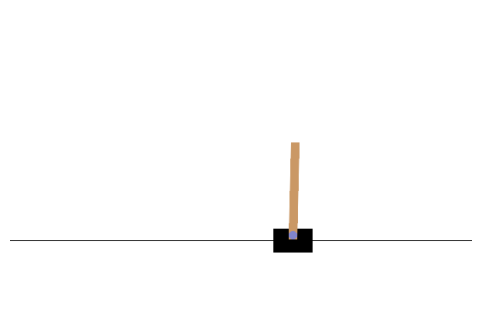

In [12]:
# Test the function with a few steps
env = gym.make(environment_name, render_mode="rgb_array")
obs, _ = env.reset()
for _ in range(200):
    action = hill_climbing_agent.calculate_action(obs)
    obs, _, done, _, _ = env.step(action)  # Take a random action
    display_environment(env)
    if done:
        break

## Exercise: Implement Policy Gradient Agent

Next we want to implement a policy gradient agent instead of the hill climbing.

As exercise, you should implement the training of the agent, all else will be given.

### Build the model

We can build a similar model as before.

For the loss calculation later, we will need not only the selected action, but also the (log) probability of the selected action and the gradient on it. We should make it possible to save this from the policy network. So we implement the `act` method so that it return both the selected action and the log of the probability of choosing this action. We can use the method `log_prob` from `Categorical`. For the log_prob, return the tensor from torch instead of the value (i.e. do not use `item`)


In [21]:
# Define the policy network
class PolicyNetwork2(torch.nn.Module):
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork2, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(observation_space.shape[0], 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, action_space.n),
            torch.nn.Softmax(dim=-1),
        )

    def forward(self, x):
        return self.fc(x)

    def act(self, obs):
        # calculate the action and return it
        obs = torch.from_numpy(obs).float().unsqueeze(0)
        probs = self.forward(obs)
        m = torch.distributions.Categorical(probs=probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

## Agent class

Now we are ready to implement the agent class. We will start with the class definition and the `__init__` method. Check the parameters and the descriptions as they will be used in the implementation. There is one additional array `log_prob` to save the log probabilities of the actions.

In [22]:
class VPGAgent:
    """
    Implementation of (vanilla) policy gradient agent
    """

    def __init__(self, observation_space, action_space,
                 gamma: float = 0.99,
                 learning_rate: float = 0.001):
        """
        Initialize agent
        Args:
            observation_space: the observation space of the environment
            action_space: the action space of the environment
            gamma: the discount factor
            learning_rate: the learning rate
        """
        self.observation_space = observation_space
        self.action_space = action_space
        self.gamma = gamma
        self.learning_rate = learning_rate

        # generate the model
        self.policy_network = PolicyNetwork2(observation_space, action_space)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)

        # arrays to store an episode for training
        self.obs = []
        self.rewards = []
        self.actions = []
        self.log_probs = []

### Action

The model directly calculates the policy, so we just have to draw an action from the resulting probability distribution.

In [23]:
%%add_to VPGAgent

def calculate_action(self, obs):
    """
    Calculate the action to take
    Args:
        obs: the observation
    Returns:
        the action to take, the log probability of the action
    """
    return self.policy_network.act(obs)

## Step functions and training

Next we will add the step functions and the _training_ inside them.

### Step and training


Simular to MC methods, updates only occur at the end of episodes and we only use the calculated return once for the gradient, however we do this for each of the actions during this episode. Therefor the update batch has the length of an episode.

The update of the gradients is according to

$$
\theta_{k+1} = \theta_k + \alpha \nabla_\theta J(\pi_\theta)
$$

where $J(\pi_\theta)$ is the loss function. In general the gradient of the loss functionhas the form

$$
\nabla\theta J(\pi\theta) = \mathbb{E}\left[\sum_{t=0}^T \nabla_\theta\Phi_t\log\pi_\theta(a_t| s_t) \right]
$$

where there are different choices for $\Phi_t$. We can for example use

$$
\Phi_t = G
$$
where $G$ is the (total) return of the episode, or use the obtained return from each state, sometimes also called the sum of the discounted future rewards.
$$
\Phi_t = \sum_{t'=t}^T R_t
$$
It can be proven, that all these choices actually lead to the same expectation of the gradient. I would suggest to use the sum of discounted future rewards.

It can also help to normalize the values to zero mean and standard deviation.

In [24]:
%%add_to VPGAgent

def step(self, obs, reward: float, done: bool):

    if reward == None:
        # first step
        self.obs.append(obs)
        action, log_prob = self.calculate_action(obs)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        return action

    # udpate the reward from the last time step (so that all arrays should now have the same length)
    self.rewards.append(reward)

    if not done:
        self.obs.append(obs)
        action, log_prob = self.calculate_action(obs)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        return action
    else:
        # an episode is finished, so we calculate the gradient and update the weights
        assert len(self.obs) == len(self.actions)
        assert len(self.obs) == len(self.rewards)
        assert len(self.obs) == len(self.log_probs)

        # Here you have to do the implementation:
        # - calculate the returns from each step, 
        # - calculate the performance (loss) function
        # - calculate the gradient
        # - change the weights bu doing a step in the obtimizer
       


        del self.rewards[:]
        del self.obs[:]
        del self.actions[:]
        del self.log_probs[:]

        return None

In [25]:
# Test implementation
env = gym.make(environment_name)
eval_env = gym.make(environment_name)

obs, info = env.reset()
np.random.seed(0)

agent = VPGAgent(env.observation_space,
                 env.action_space,
                 gamma=0.99,
                 learning_rate=0.001)

# Check if one complete episode runs through
obs, _ = env.reset()
action = agent.step(obs, None, False)
done = False
truncated = False
while not done and not truncated:
    obs, reward, done, truncated, _ = env.step(action)
    action = agent.step(obs, reward, done)

### Training and evaluation

We add the train and evaluate methods in the agents, similar to the last exercise so that it is easier to run some tests. Nothing to code here. Note that the number of steps for training are episodes here, as we only change the weights at the end of episodes.

In [26]:
%%add_to VPGAgent
def train(self, env: gym.Env,
          nr_episodes_train: int,
          eval_env: gym.Env,
          eval_frequency: int,
          eval_nr_episodes: int,
          eval_gamma: float = 1.0):
    """
    Train the agent on the given environment for the given number of episodes.
    Args:
        env: The environment on which to train the agent
        nr_episodes_train: the number of episodes to train
        eval_env: the environment to use for evaluation
        eval_frequency: Frequency of evaluation of the trained agent (in episodes)
        eval_nr_episodes: The number of episodes to evaluate
    """
    nr_episodes = 0
    while True:
        obs, _ = env.reset()
        a = self.step(obs, None, False)
        done = False
        truncated = False
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            a = self.step(obs, reward, done or truncated)

        nr_episodes += 1
        if nr_episodes % eval_frequency == 0:
            rewards = self.evaluate(eval_env, eval_nr_episodes, eval_gamma)
            print(f'Evaluation: Episode trained {nr_episodes}, mean reward: {np.mean(rewards)}')

        if nr_episodes > nr_episodes_train:
            return
def evaluate(self, env: gym.Env, nr_episodes: int, gamma: float = 1.0):
    """
    Evaluate the agent on the given environment for the given number of episodes.
    Args:
        env: the environment on which to evaluate the agent
        nr_episodes: the number of episodes to evaluate

    Returns:
        the rewards for the episodes
    """
    rewards = []
    for e in range(nr_episodes):
        obs, _ = env.reset()
        a,_ = self.calculate_action(obs)
        done = False
        truncated = False
        episode_reward = 0
        gamma_current = gamma
        while not done and not truncated:
            obs, reward, done, truncated, _ = env.step(a)
            a, _ = self.calculate_action(obs)
            episode_reward += gamma_current * reward
            gamma_current *= gamma
        rewards.append(episode_reward)
    return rewards

We train the agent for a number of steps to test

In [27]:
env = gym.make(environment_name)
eval_env = gym.make(environment_name)

obs, info = env.reset()
np.random.seed(0)

agent = VPGAgent(env.observation_space,
                 env.action_space,
                 gamma=0.99,
                 learning_rate=0.001)

agent.train(env, nr_episodes_train=1000, eval_env=eval_env, eval_frequency=25, eval_nr_episodes=1, eval_gamma=1.0)

# calculate return at end using evaluation
return_eval = agent.evaluate(env=eval_env, nr_episodes=1, gamma=1.0)

print(f'Evaluation: {return_eval}')

Evaluation: Episode trained 25, mean reward: 20.0
Evaluation: Episode trained 50, mean reward: 42.0
Evaluation: Episode trained 75, mean reward: 27.0
Evaluation: Episode trained 100, mean reward: 22.0
Evaluation: Episode trained 125, mean reward: 43.0
Evaluation: Episode trained 150, mean reward: 25.0
Evaluation: Episode trained 175, mean reward: 15.0
Evaluation: Episode trained 200, mean reward: 71.0
Evaluation: Episode trained 225, mean reward: 13.0
Evaluation: Episode trained 250, mean reward: 16.0
Evaluation: Episode trained 275, mean reward: 30.0
Evaluation: Episode trained 300, mean reward: 24.0
Evaluation: Episode trained 325, mean reward: 63.0
Evaluation: Episode trained 350, mean reward: 66.0
Evaluation: Episode trained 375, mean reward: 156.0
Evaluation: Episode trained 400, mean reward: 65.0
Evaluation: Episode trained 425, mean reward: 45.0
Evaluation: Episode trained 450, mean reward: 97.0
Evaluation: Episode trained 475, mean reward: 39.0
Evaluation: Episode trained 500, 

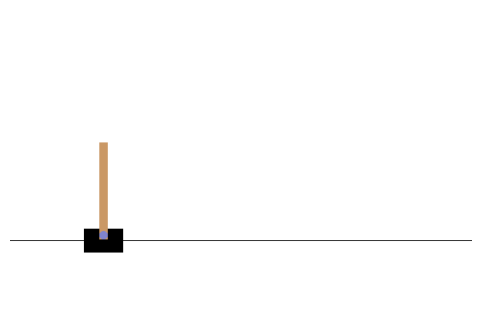

In [28]:
env = gym.make(environment_name, render_mode='rgb_array')
obs, _  = env.reset()
for _ in range(200):
    action, _ = agent.calculate_action(obs)
    obs, _, _, _,_ = env.step(action)  # Take a random action
    display_environment(env)